## Kaggle Competition Project - Predicting Hourly Building Energy Use

The summary explanation for this project can be found in the README file of this repo. There is sparse markdown throughout to help with code readability.

The original goal was to use all observations of this dataset as the train data and submit predictions on the kaggle competition test data as per the instructions of the competition. Due to running out of time, in an attempt to get a performance metric, a late train/test split is performed. Several operations have been done prior to this train test split (i.e. imputing) so data leakage is present and the results are more or less meaningless. This project ends up being an exercise in data cleaning and data understanding.

In [82]:
import pandas as pd
import numpy as np
import itertools

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, mean_squared_log_error

from statsmodels.formula.api import ols

from scipy import stats

Importing Datasets

In [83]:
df_meta = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/building_metadata.csv')
df = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/train.csv')
df_weather = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/weather_train.csv')
df_sample = pd.read_csv('/Users/evanjays/Desktop/Programming/Flatiron/CAPSTONE/data_big/ashrae-energy-prediction/sample_submission.csv')

In [84]:
df_weather['timestamp'] = pd.to_datetime(df_weather['timestamp'])
df_weather_time = df_weather.copy(deep=True)

df_weather_time.set_index('timestamp',drop=True,inplace=True)

### Data Exploration

Exploring weather data - Peak temperatures don't make sense based on time. Need to shift time to have temperatures match up with their respective local times.

<AxesSubplot:xlabel='timestamp'>

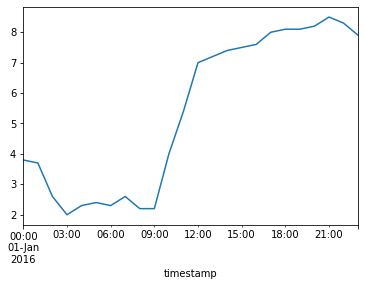

In [85]:
df_weather_time[df_weather_time['site_id'] == 1]['air_temperature'][:24].plot()

Summary of weather data columns

In [86]:
df_weather_time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 139773 entries, 2016-01-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   site_id             139773 non-null  int64  
 1   air_temperature     139718 non-null  float64
 2   cloud_coverage      70600 non-null   float64
 3   dew_temperature     139660 non-null  float64
 4   precip_depth_1_hr   89484 non-null   float64
 5   sea_level_pressure  129155 non-null  float64
 6   wind_direction      133505 non-null  float64
 7   wind_speed          139469 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 9.6 MB


There are 16 sites of weather data. Below shows a day's worth of air temperature data. Majority of the peak temperatures do not line up properly with the time (i.e. air temperature peaking at night)

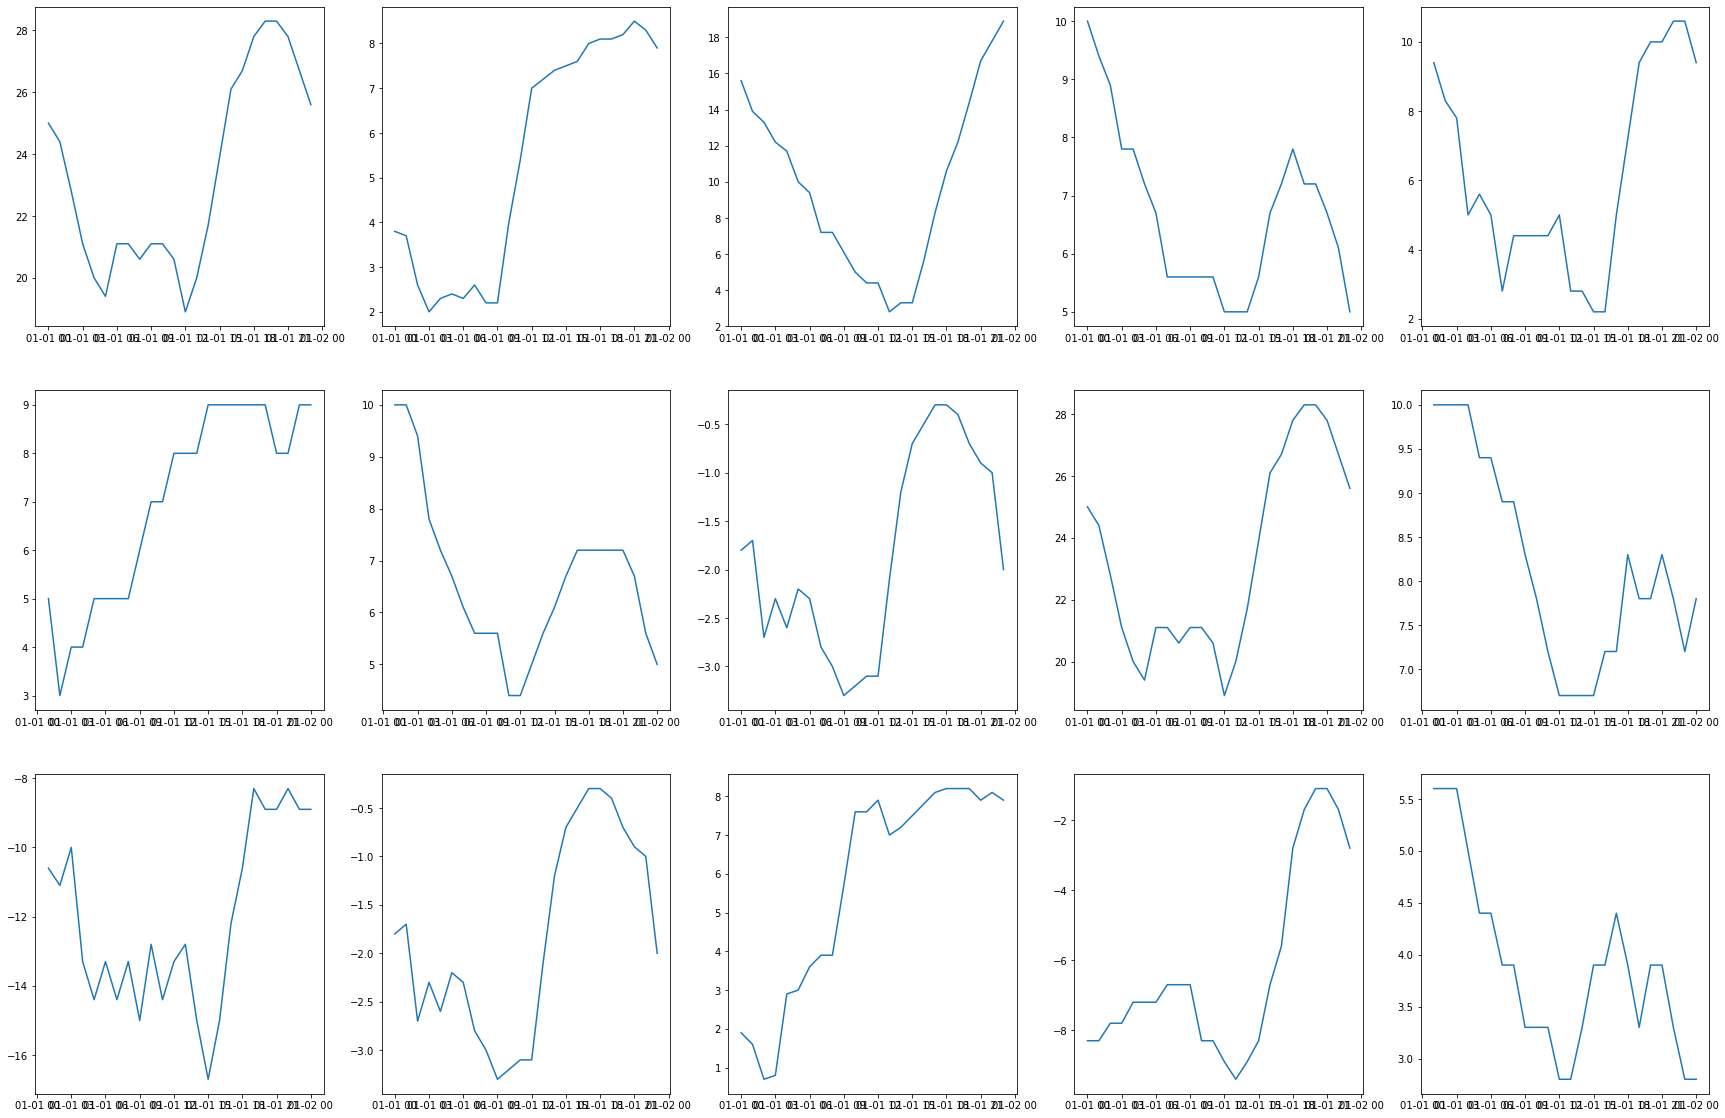

In [87]:
fig, ax = plt.subplots(ncols=5,nrows=3,figsize=(30,20))
count = 0
for i in range(3):
    for j in range(5):
        ax[i,j].plot(df_weather_time[df_weather_time['site_id'] == count]['air_temperature'][:24])
        count += 1

Showing the air temperature over the full year for each site

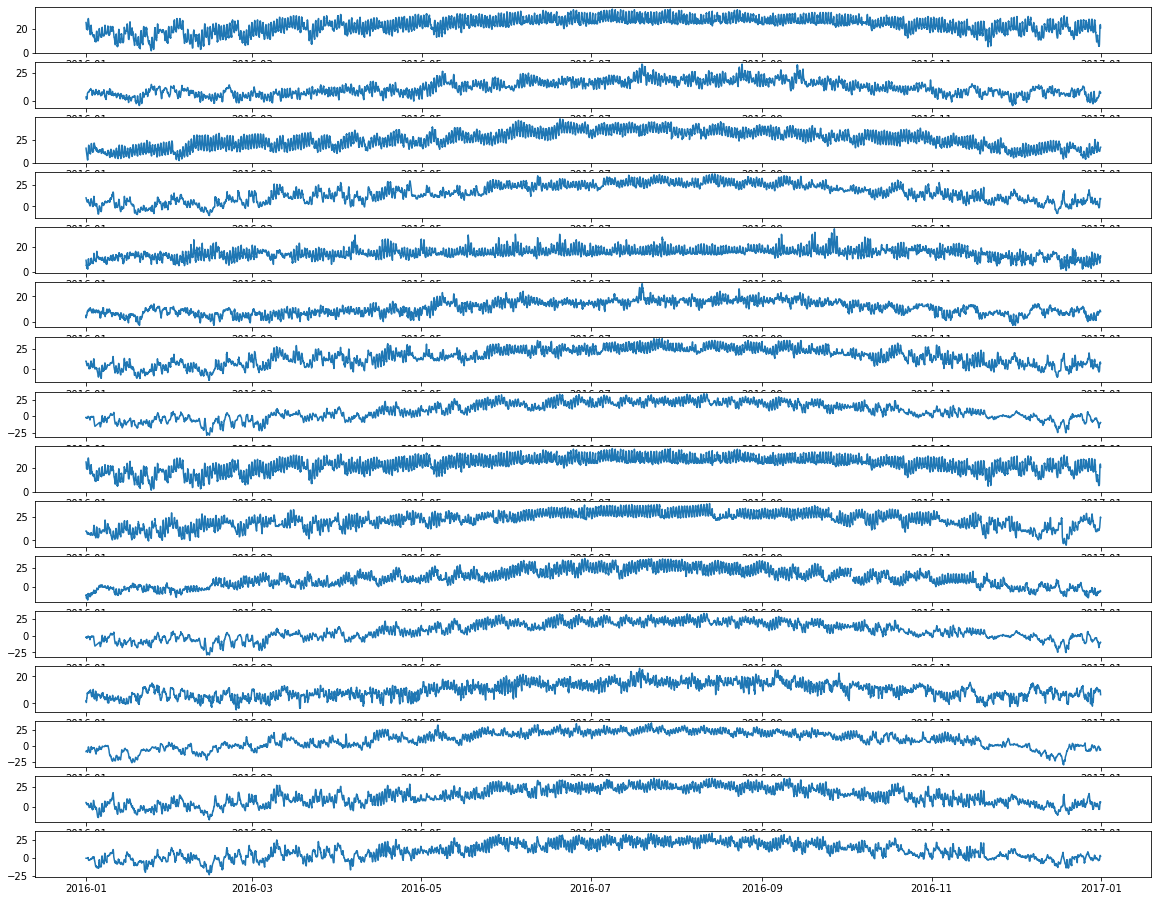

In [88]:
fig, axes = plt.subplots(nrows=16,figsize=(20,16))
for i in range(16):
    df_weather_temp = df_weather_time[df_weather_time['site_id'] == i]
    axes[i].plot(df_weather_temp['air_temperature'])

### Preprocessing Weather Data

Attempting to shift each site to proper local time.

In [90]:
def time_shift(dataframe,site):
    time_shift_dict = {0:-3,1:-5,2:-7,3:-9,4:-7,5:0,6:-12,7:-3,8:-4,9:-10,10:-3,11:-3,12:-16,13:-5,14:-12,15:-5}
    df_temp_1 = pd.DataFrame()
    df_temp_1 = dataframe.shift(periods=time_shift_dict[site])
    df_temp_1['site_id'].ffill(inplace=True)
    df_temp_1['air_temperature'].ffill(inplace=True)
    return df_temp_1

Imputing missing weather data values and creating calendar features

In [91]:
# Create Weather input variables sampled daily
site_weather_list = []
df_weekday = pd.DataFrame([1,0,0,1,1,1,1] * 52 + [1,0],columns=['is_weekday'])
for i in range(16):
    df_temp = pd.DataFrame()
    df_temp = df_weather_time[df_weather_time['site_id'] == i]
    df_temp = time_shift(df_temp,i).resample('D').mean()
    df_temp['site_id'].ffill(inplace=True)
    df_temp['air_temperature'].ffill(inplace=True)
    df_temp.reset_index(inplace=True)
    df_temp = pd.concat([df_temp,df_weekday],axis=1)
    site_weather_list.append(df_temp)

df_weather_bm = pd.DataFrame()
for dataframe in site_weather_list:
    dataframe.reset_index(inplace=True,drop=True)
    df_weather_bm = pd.concat([df_weather_bm,dataframe])

si = SimpleImputer()

df_weather_bm['cloud_coverage'] = si.fit_transform(df_weather_bm[['cloud_coverage']])
df_weather_bm['dew_temperature'] = si.fit_transform(df_weather_bm[['dew_temperature']])
df_weather_bm['sea_level_pressure'] = si.fit_transform(df_weather_bm[['sea_level_pressure']])
df_weather_bm['precip_depth_1_hr'] = si.fit_transform(df_weather_bm[['precip_depth_1_hr']])
df_weather_bm['wind_direction'] = si.fit_transform(df_weather_bm[['wind_direction']])
df_weather_bm['wind_speed'] = si.fit_transform(df_weather_bm[['wind_speed']])

### Preprocessing Building Metadata

Imputing missing building metadata

In [92]:
use_dict = {}
for use in df_meta['primary_use'].unique():
    if df_meta[df_meta['primary_use'] == use]['floor_count'].isna().sum() == df_meta[df_meta['primary_use'] == use]['floor_count'].shape[0]:
        use_dict[use] = 1
    else:
        use_dict[use] = round(df_meta[df_meta['primary_use'] == use]['floor_count'].median())

def impute_num_floors(num_floors):
    if num_floors > 0:
        return num_floors
    else:
        return use_dict[use]

metadata_list = []
for idx,use in enumerate(df_meta['primary_use'].unique()):
    df_temp = pd.DataFrame()
    df_temp = df_meta[df_meta['primary_use'] == use].copy(deep=True)
    df_temp['floor_count'] = df_temp['floor_count'].map(impute_num_floors)
    metadata_list.append(df_temp.copy(deep=True))

df_meta_imputed = pd.DataFrame()
for dataframe in metadata_list:
    df_meta_imputed = pd.concat([df_meta_imputed,dataframe])

df_meta_imputed.drop(['year_built'],inplace=True,axis=1)

### Merging Metadata with Weather Data

In [93]:
df_meta_weather = df_meta_imputed.merge(df_weather_bm,how='right',on='site_id')

### Resampling Meter Reading Data

In [94]:
meter_data_list = []
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df[df['meter'] == 0]
for i in df['building_id'].unique():
    df_temp = pd.DataFrame()
    df_temp = df[df['building_id'] == i].copy(deep=True)
    df_temp.set_index('timestamp',inplace=True)
    df_temp = df_temp.groupby('building_id').resample('D').sum()
    meter_data_list.append(df_temp)

df_meter_bm = pd.DataFrame()
for dataframe in meter_data_list:
    dataframe.drop(['building_id'],inplace=True,axis=1)
    dataframe.reset_index(inplace=True) 
    df_meter_bm = pd.concat([df_meter_bm,dataframe])

### Merging Meter Reading Data with main Dataframe

In [95]:
df_final = df_meter_bm.merge(df_meta_weather,how='left',on=['building_id','timestamp'])
df_final.drop(['meter'],axis=1,inplace=True)
df_final = df_final[df_final['meter_reading'] > 0]

In [96]:
# Dropping Outliers
df_final = df_final[(np.abs(stats.zscore(df_final['meter_reading'])) < 3)]

In [97]:
df_final.describe()

,building_id,meter_reading,site_id,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_weekday
count,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000,476945.000000
mean,722.873239,3391.447004,6.914697,87170.138261,3.146036,15.859094,2.695987,8.147020,1.071586,1016.319763,174.531722,3.561367,0.713399
std,407.131323,4719.497987,4.894557,99575.012539,2.218966,9.918315,2.310794,9.640054,3.056724,6.488860,71.204479,1.639711,0.452174
min,0.000000,0.009400,0.000000,283.000000,1.000000,-24.495833,0.000000,-30.054167,-1.000000,973.327273,1.111111,0.378261,0.000000
25%,370.000000,565.847000,3.000000,22334.000000,1.000000,9.133333,0.750000,1.270833,0.000000,1012.508333,120.000000,2.391667,0.000000
50%,709.000000,1635.981000,5.000000,57189.000000,2.000000,16.505000,2.400811,9.041667,0.000000,1016.144075,170.416667,3.291667,1.000000
75%,1071.000000,4008.000000,13.000000,111623.000000,4.000000,23.571429,4.000000,15.504167,1.661076,1020.116667,231.739130,4.441667,1.000000
max,1448.000000,31204.000000,15.000000,875000.000000,26.000000,39.958333,9.000000,24.504167,134.000000,1044.450000,345.833333,13.625000,1.000000


In [98]:
test_df = pd.DataFrame()
train_df = pd.DataFrame()
for i in range(1449):
    if i % 5 == 0:
        test_df = pd.concat([test_df,df_final[df_final['building_id'] == i]])
    else:
        train_df = pd.concat([train_df,df_final[df_final['building_id'] == i]])

In [99]:
# Taking log of target to keep from predicting negative values for energy usage

y_train = train_df['meter_reading'].copy(deep=True).map(np.log1p)
X_train = train_df.drop(['meter_reading','building_id','timestamp'],axis=1)

y_test = test_df['meter_reading'].copy(deep=True).map(np.log1p)
X_test = test_df.drop(['meter_reading','building_id','timestamp'],axis=1)

In [100]:
X_train

,site_id,primary_use,square_feet,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,is_weekday
367,0,Education,2720,4.0,18.733333,6.400000,14.612500,-0.041667,1018.941667,130.833333,4.154167,0
370,0,Education,2720,4.0,14.433333,2.000000,7.666667,0.000000,1023.133333,143.333333,6.287500,1
374,0,Education,2720,4.0,17.479167,8.111111,16.208333,2.375000,1011.904167,95.000000,1.987500,0
375,0,Education,2720,4.0,18.558333,6.500000,15.391667,-0.041667,1012.970833,249.583333,4.370833,0
377,0,Education,2720,4.0,10.950000,2.842105,0.770833,0.000000,1022.208333,301.666667,3.058333,1
...,...,...,...,...,...,...,...,...,...,...,...,...
507064,15,Office,92271,2.0,3.575000,3.500000,0.016667,2.600000,1012.237500,247.083333,5.229167,1
507065,15,Office,92271,2.0,-2.208696,2.000000,-5.543478,1.500000,1019.230435,221.304348,3.552174,1
507066,15,Office,92271,2.0,-0.445833,0.000000,-3.220833,-0.166667,1005.408333,193.750000,4.912500,1
507067,15,Office,92271,2.0,-1.895833,2.400811,-5.208333,-1.000000,1005.308333,273.333333,6.412500,1


In [101]:
ohe = OneHotEncoder(drop='first')

ohe_train_array = ohe.fit_transform(X_train[['primary_use']])
ohe_train_df = pd.DataFrame(ohe_train_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

ohe_test_array = ohe.transform(X_test[['primary_use']])
ohe_test_df = pd.DataFrame(ohe_test_array.todense(),columns=[name[3:] for name in ohe.get_feature_names()])

X_train.reset_index(inplace=True,drop=True)
X_train_ohe = pd.concat([X_train,ohe_train_df],axis=1)
X_train_ohe.drop(['primary_use'],axis=1,inplace=True)

X_test.reset_index(inplace=True,drop=True)
X_test_ohe = pd.concat([X_test,ohe_test_df],axis=1)
X_test_ohe.drop(['primary_use'],axis=1,inplace=True)

In [102]:
column_names = [x.replace(' ','_').replace('/','_') for x in X_train_ohe.columns]

In [103]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_ohe)
X_train_scaled = pd.DataFrame(X_train_scaled,columns=column_names)

X_test_scaled = ss.transform(X_test_ohe)
X_test_scaled = pd.DataFrame(X_test_scaled,columns=column_names)

<AxesSubplot:>

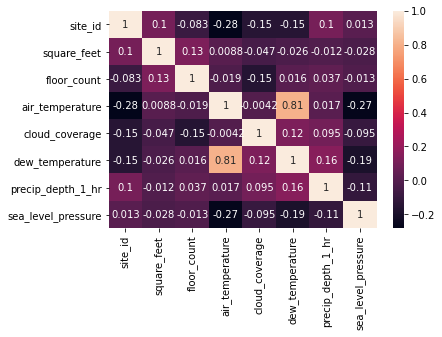

In [104]:
sns.heatmap(X_train_ohe.iloc[:,:8].corr(),annot=True)

In [105]:
lr = LinearRegression()

lr.fit(X_train_scaled,y_train)

cross_val_score(lr,X_train_scaled,y_train)

lr.score(X_test_scaled,y_test)

0.38287092646568166

In [111]:
rfe = RFE(lr,n_features_to_select=15)

rfe.fit(X_train_scaled,y_train)

keep_list = [(k,v) for k,v in zip(X_train_scaled.columns,rfe.support_)]
keep_string = ''
for k,v in keep_list:
    if v:
        keep_string += k + '+'
keep_string = keep_string[:-1]
keep_string

'site_id+square_feet+floor_count+air_temperature+cloud_coverage+dew_temperature+wind_speed+is_weekday+Entertainment_public_assembly+Healthcare+Lodging_residential+Office+Other+Parking+Religious_worship'

In [112]:
X_train_scaled.reset_index(drop=True,inplace=True)
y_train.reset_index(drop=True,inplace=True)
X_train_final = pd.concat([X_train_scaled,y_train],axis=1)

X_test_scaled.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True)
X_test_final = pd.concat([X_test_scaled,y_test],axis=1)

In [113]:
formula = f'meter_reading ~ {keep_string}'
model = ols(formula,X_train_final).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          meter_reading   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.402
Method:                 Least Squares   F-statistic:                 1.712e+04
Date:                Tue, 23 Nov 2021   Prob (F-statistic):               0.00
Time:                        12:35:26   Log-Likelihood:            -6.1076e+05
No. Observations:              381909   AIC:                         1.222e+06
Df Residuals:                  381893   BIC:                         1.222e+06
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                         7.2437      0.002   3737.955      0.000       7.240       7.247
site_id                           0.1451      0.002     66.268      0.000       0.141       0.149
square_feet                       0.7962      0.002    386.439      0.000       0.792       0.800
floor_count                       0.4165      0.003    152.631      0.000       0.411       0.422
air_temperature                   0.2530      0.004     70.340      0.000       0.246       0.260
cloud_coverage                    0.1164      0.002     55.327      0.000       0.112       0.121
dew_temperature                  -0.1985      0.003    -57.246      0.000      -0.205      -0.192
wind_speed                       -0.0853      0.002    -41.694      0.000      -0.089      -0.081
is_weekday                        0.0802      0.002     41.383      0.000       0.076       0.084
Entertainment_public_assembly    -0.0971      0.002    -44.544      0.000      -0.101      -0.093
Healthcare                        0.1159      0.002     58.425      0.000       0.112       0.120
Lodging_residential              -0.2428      0.002   -100.984      0.000      -0.248      -0.238
Office                            0.0859      0.002     40.422      0.000       0.082       0.090
Other                            -0.0936      0.002    -47.063      0.000      -0.098      -0.090
Parking                          -0.1938      0.002    -95.897      0.000      -0.198      -0.190
Religious_worship                -0.1064      0.002    -54.649      0.000      -0.110      -0.103
==============================================================================
Omnibus:                    88178.978   Durbin-Watson:                   0.089
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           335890.856
Skew:                          -1.118   Prob(JB):                         0.00
Kurtosis:                       7.014   Cond. No.                         3.61
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [109]:
y_test.describe()

count    95036.000000
mean         7.212661
std          1.559062
min          0.009356
25%          6.413877
50%          7.327301
75%          8.251884
max         10.348014
Name: meter_reading, dtype: float64

In [110]:
y_test_preds = lr.predict(X_test_scaled)
np.sqrt(mean_squared_error(y_test,y_test_preds))
np.sqrt(mean_squared_log_error(y_test,y_test_preds))

0.2154350025532549